In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import pickle
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fc1 = nn.Linear(128 * 3 * 3, 1000)
        self.fc2 = nn.Linear(1000, 10)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.dropout(self.pool1(x))
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [3]:
batch_size = 128
# Load CIFAR10 train dataset
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=2)
print(len(train_set))

# Load test dataset
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=None)
test_loader = DataLoader(test_set, batch_size, shuffle=False, num_workers=2)
print(len(test_set))

# Calculate mean and standard deviation of the dataset
mean = train_set.data.mean(axis=(0,1,2)) / 255  # Calculate mean
std = train_set.data.std(axis=(0,1,2)) / 255    # Calculate standard deviation

# Define transforms including whitening
transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Calculate mean and standard deviation of the dataset
mean = test_set.data.mean(axis=(0,1,2)) / 255  # Calculate mean
std = test_set.data.std(axis=(0,1,2)) / 255    # Calculate standard deviation

# Define transforms including whitening
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# regenerate datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform1)
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=2)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform2)
test_loader = DataLoader(test_set, batch_size, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:14<00:00, 11605791.33it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
50000
Files already downloaded and verified
10000


In [4]:
# Create an instance of the CNN model
model = CNN()
model.to('cuda')
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epoch = 50

# logs
loss_hists = {'train':[],'test': []}
acc_hists = {'train':[],'test': []}

# Train the model
for epoch in range(num_epoch):  # loop over the dataset multiple times
    train_loss = 0
    correct_num = 0
    for data in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epoch}"):
        model.train()
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        pred = outputs.argmax(dim=1)
        correct_num += (pred == labels).sum().item()
        
    average_loss = train_loss/len(train_loader)
    acc = correct_num/(len(train_loader)*batch_size)
    loss_hists['train'].append(average_loss)
    acc_hists['train'].append(acc)
    print(f"Epoch {epoch + 1}/{num_epoch}, Training Loss: {average_loss:.4f}, Training accuracy: {acc:.4f}")
    
    model.eval()
    with torch.no_grad():
        correct_num = 0
        val_loss = 0
        for test_data in test_loader:
            
            test_inputs, test_labels = test_data
            test_inputs, test_labels = test_inputs.to('cuda'), test_labels.to('cuda')
            test_output = model(test_inputs)
            loss = criterion(test_output,test_labels)
            val_loss+=loss
            
            test_pred = test_output.argmax(dim=1)
            correct_num += (test_pred == test_labels).sum().item()
            
        acc = correct_num/ (len(test_loader)*batch_size)
        average_val_loss = val_loss/len(test_loader)
        
        loss_hists['test'].append(average_val_loss)
        acc_hists['test'].append(acc)
        print(f'Epoch {epoch + 1}/{num_epoch}, Validation loss: {average_val_loss:.4f}, Validation accuracy: {acc:.4f}')


Epoch 1/50: 100%|██████████| 391/391 [00:09<00:00, 41.62it/s] 


Epoch 1/50, Training Loss: 1.6980, Training accuracy: 0.3789
Epoch 1/50, Validation loss: 1.4943, Validation accuracy: 0.4456


Epoch 2/50: 100%|██████████| 391/391 [00:08<00:00, 46.44it/s] 


Epoch 2/50, Training Loss: 1.4236, Training accuracy: 0.4855
Epoch 2/50, Validation loss: 1.3550, Validation accuracy: 0.5092


Epoch 3/50: 100%|██████████| 391/391 [00:08<00:00, 46.26it/s] 


Epoch 3/50, Training Loss: 1.3299, Training accuracy: 0.5218
Epoch 3/50, Validation loss: 1.3510, Validation accuracy: 0.5100


Epoch 4/50: 100%|██████████| 391/391 [00:08<00:00, 47.36it/s] 


Epoch 4/50, Training Loss: 1.2708, Training accuracy: 0.5450
Epoch 4/50, Validation loss: 1.2553, Validation accuracy: 0.5564


Epoch 5/50: 100%|██████████| 391/391 [00:08<00:00, 48.20it/s] 


Epoch 5/50, Training Loss: 1.2239, Training accuracy: 0.5626
Epoch 5/50, Validation loss: 1.2234, Validation accuracy: 0.5654


Epoch 6/50: 100%|██████████| 391/391 [00:08<00:00, 48.50it/s] 


Epoch 6/50, Training Loss: 1.1911, Training accuracy: 0.5763
Epoch 6/50, Validation loss: 1.1742, Validation accuracy: 0.5803


Epoch 7/50: 100%|██████████| 391/391 [00:08<00:00, 47.07it/s] 


Epoch 7/50, Training Loss: 1.1594, Training accuracy: 0.5896
Epoch 7/50, Validation loss: 1.1278, Validation accuracy: 0.5964


Epoch 8/50: 100%|██████████| 391/391 [00:08<00:00, 48.80it/s] 


Epoch 8/50, Training Loss: 1.1322, Training accuracy: 0.5995
Epoch 8/50, Validation loss: 1.1157, Validation accuracy: 0.5984


Epoch 9/50: 100%|██████████| 391/391 [00:08<00:00, 45.83it/s] 


Epoch 9/50, Training Loss: 1.1091, Training accuracy: 0.6086
Epoch 9/50, Validation loss: 1.1090, Validation accuracy: 0.6020


Epoch 10/50: 100%|██████████| 391/391 [00:07<00:00, 49.07it/s] 


Epoch 10/50, Training Loss: 1.0906, Training accuracy: 0.6161
Epoch 10/50, Validation loss: 1.0841, Validation accuracy: 0.6089


Epoch 11/50: 100%|██████████| 391/391 [00:08<00:00, 47.72it/s] 


Epoch 11/50, Training Loss: 1.0710, Training accuracy: 0.6211
Epoch 11/50, Validation loss: 1.0903, Validation accuracy: 0.6052


Epoch 12/50: 100%|██████████| 391/391 [00:09<00:00, 40.71it/s] 


Epoch 12/50, Training Loss: 1.0552, Training accuracy: 0.6275
Epoch 12/50, Validation loss: 1.0989, Validation accuracy: 0.6059


Epoch 13/50: 100%|██████████| 391/391 [00:08<00:00, 46.11it/s] 


Epoch 13/50, Training Loss: 1.0385, Training accuracy: 0.6323
Epoch 13/50, Validation loss: 1.0787, Validation accuracy: 0.6147


Epoch 14/50: 100%|██████████| 391/391 [00:08<00:00, 47.31it/s] 


Epoch 14/50, Training Loss: 1.0241, Training accuracy: 0.6414
Epoch 14/50, Validation loss: 1.0404, Validation accuracy: 0.6259


Epoch 15/50: 100%|██████████| 391/391 [00:08<00:00, 45.99it/s] 


Epoch 15/50, Training Loss: 1.0115, Training accuracy: 0.6453
Epoch 15/50, Validation loss: 1.0559, Validation accuracy: 0.6233


Epoch 16/50: 100%|██████████| 391/391 [00:08<00:00, 45.87it/s] 


Epoch 16/50, Training Loss: 0.9985, Training accuracy: 0.6494
Epoch 16/50, Validation loss: 1.0227, Validation accuracy: 0.6328


Epoch 17/50: 100%|██████████| 391/391 [00:07<00:00, 48.98it/s] 


Epoch 17/50, Training Loss: 0.9860, Training accuracy: 0.6553
Epoch 17/50, Validation loss: 1.0126, Validation accuracy: 0.6395


Epoch 18/50: 100%|██████████| 391/391 [00:08<00:00, 47.89it/s] 


Epoch 18/50, Training Loss: 0.9786, Training accuracy: 0.6558
Epoch 18/50, Validation loss: 1.0075, Validation accuracy: 0.6412


Epoch 19/50: 100%|██████████| 391/391 [00:08<00:00, 47.74it/s] 


Epoch 19/50, Training Loss: 0.9677, Training accuracy: 0.6584
Epoch 19/50, Validation loss: 0.9964, Validation accuracy: 0.6455


Epoch 20/50: 100%|██████████| 391/391 [00:08<00:00, 47.73it/s] 


Epoch 20/50, Training Loss: 0.9566, Training accuracy: 0.6665
Epoch 20/50, Validation loss: 0.9815, Validation accuracy: 0.6490


Epoch 21/50: 100%|██████████| 391/391 [00:08<00:00, 48.33it/s] 


Epoch 21/50, Training Loss: 0.9458, Training accuracy: 0.6687
Epoch 21/50, Validation loss: 0.9524, Validation accuracy: 0.6572


Epoch 22/50: 100%|██████████| 391/391 [00:08<00:00, 48.82it/s] 


Epoch 22/50, Training Loss: 0.9405, Training accuracy: 0.6701
Epoch 22/50, Validation loss: 0.9670, Validation accuracy: 0.6541


Epoch 23/50: 100%|██████████| 391/391 [00:07<00:00, 49.75it/s] 


Epoch 23/50, Training Loss: 0.9287, Training accuracy: 0.6748
Epoch 23/50, Validation loss: 0.9603, Validation accuracy: 0.6562


Epoch 24/50: 100%|██████████| 391/391 [00:08<00:00, 47.01it/s] 


Epoch 24/50, Training Loss: 0.9251, Training accuracy: 0.6741
Epoch 24/50, Validation loss: 0.9356, Validation accuracy: 0.6660


Epoch 25/50: 100%|██████████| 391/391 [00:08<00:00, 47.81it/s] 


Epoch 25/50, Training Loss: 0.9167, Training accuracy: 0.6777
Epoch 25/50, Validation loss: 0.9326, Validation accuracy: 0.6679


Epoch 26/50: 100%|██████████| 391/391 [00:08<00:00, 47.40it/s] 


Epoch 26/50, Training Loss: 0.9094, Training accuracy: 0.6831
Epoch 26/50, Validation loss: 0.9347, Validation accuracy: 0.6681


Epoch 27/50: 100%|██████████| 391/391 [00:08<00:00, 45.53it/s] 


Epoch 27/50, Training Loss: 0.9011, Training accuracy: 0.6852
Epoch 27/50, Validation loss: 0.9259, Validation accuracy: 0.6700


Epoch 28/50: 100%|██████████| 391/391 [00:07<00:00, 49.43it/s] 


Epoch 28/50, Training Loss: 0.8946, Training accuracy: 0.6867
Epoch 28/50, Validation loss: 0.9384, Validation accuracy: 0.6668


Epoch 29/50: 100%|██████████| 391/391 [00:07<00:00, 50.27it/s] 


Epoch 29/50, Training Loss: 0.8902, Training accuracy: 0.6883
Epoch 29/50, Validation loss: 0.9295, Validation accuracy: 0.6719


Epoch 30/50: 100%|██████████| 391/391 [00:07<00:00, 49.78it/s] 


Epoch 30/50, Training Loss: 0.8857, Training accuracy: 0.6892
Epoch 30/50, Validation loss: 0.9133, Validation accuracy: 0.6735


Epoch 31/50: 100%|██████████| 391/391 [00:07<00:00, 48.97it/s] 


Epoch 31/50, Training Loss: 0.8772, Training accuracy: 0.6946
Epoch 31/50, Validation loss: 0.9065, Validation accuracy: 0.6770


Epoch 32/50: 100%|██████████| 391/391 [00:08<00:00, 48.43it/s] 


Epoch 32/50, Training Loss: 0.8739, Training accuracy: 0.6938
Epoch 32/50, Validation loss: 0.9150, Validation accuracy: 0.6729


Epoch 33/50: 100%|██████████| 391/391 [00:08<00:00, 48.16it/s] 


Epoch 33/50, Training Loss: 0.8658, Training accuracy: 0.6976
Epoch 33/50, Validation loss: 0.9023, Validation accuracy: 0.6785


Epoch 34/50: 100%|██████████| 391/391 [00:11<00:00, 34.06it/s] 


Epoch 34/50, Training Loss: 0.8604, Training accuracy: 0.6991
Epoch 34/50, Validation loss: 0.8985, Validation accuracy: 0.6761


Epoch 35/50: 100%|██████████| 391/391 [00:10<00:00, 37.14it/s] 


Epoch 35/50, Training Loss: 0.8561, Training accuracy: 0.7008
Epoch 35/50, Validation loss: 0.9099, Validation accuracy: 0.6758


Epoch 36/50: 100%|██████████| 391/391 [00:12<00:00, 32.42it/s] 


Epoch 36/50, Training Loss: 0.8508, Training accuracy: 0.7038
Epoch 36/50, Validation loss: 0.8884, Validation accuracy: 0.6818


Epoch 37/50: 100%|██████████| 391/391 [00:11<00:00, 33.27it/s] 


Epoch 37/50, Training Loss: 0.8464, Training accuracy: 0.7048
Epoch 37/50, Validation loss: 0.8988, Validation accuracy: 0.6785


Epoch 38/50: 100%|██████████| 391/391 [00:11<00:00, 34.14it/s] 


Epoch 38/50, Training Loss: 0.8425, Training accuracy: 0.7055
Epoch 38/50, Validation loss: 0.8944, Validation accuracy: 0.6823


Epoch 39/50: 100%|██████████| 391/391 [00:10<00:00, 36.61it/s] 


Epoch 39/50, Training Loss: 0.8370, Training accuracy: 0.7089
Epoch 39/50, Validation loss: 0.8844, Validation accuracy: 0.6835


Epoch 40/50: 100%|██████████| 391/391 [00:12<00:00, 30.10it/s]


Epoch 40/50, Training Loss: 0.8292, Training accuracy: 0.7111
Epoch 40/50, Validation loss: 0.8931, Validation accuracy: 0.6832


Epoch 41/50: 100%|██████████| 391/391 [00:11<00:00, 32.68it/s] 


Epoch 41/50, Training Loss: 0.8252, Training accuracy: 0.7120
Epoch 41/50, Validation loss: 0.8890, Validation accuracy: 0.6839


Epoch 42/50: 100%|██████████| 391/391 [00:12<00:00, 32.23it/s] 


Epoch 42/50, Training Loss: 0.8227, Training accuracy: 0.7136
Epoch 42/50, Validation loss: 0.8793, Validation accuracy: 0.6860


Epoch 43/50: 100%|██████████| 391/391 [00:12<00:00, 31.10it/s] 


Epoch 43/50, Training Loss: 0.8176, Training accuracy: 0.7153
Epoch 43/50, Validation loss: 0.8581, Validation accuracy: 0.6956


Epoch 44/50: 100%|██████████| 391/391 [00:12<00:00, 31.82it/s] 


Epoch 44/50, Training Loss: 0.8140, Training accuracy: 0.7149
Epoch 44/50, Validation loss: 0.8666, Validation accuracy: 0.6904


Epoch 45/50: 100%|██████████| 391/391 [00:13<00:00, 29.77it/s]


Epoch 45/50, Training Loss: 0.8074, Training accuracy: 0.7193
Epoch 45/50, Validation loss: 0.8657, Validation accuracy: 0.6922


Epoch 46/50: 100%|██████████| 391/391 [00:11<00:00, 34.01it/s] 


Epoch 46/50, Training Loss: 0.8040, Training accuracy: 0.7206
Epoch 46/50, Validation loss: 0.8571, Validation accuracy: 0.6947


Epoch 47/50: 100%|██████████| 391/391 [00:13<00:00, 29.65it/s]


Epoch 47/50, Training Loss: 0.8015, Training accuracy: 0.7215
Epoch 47/50, Validation loss: 0.8650, Validation accuracy: 0.6924


Epoch 48/50: 100%|██████████| 391/391 [00:11<00:00, 33.07it/s] 


Epoch 48/50, Training Loss: 0.7958, Training accuracy: 0.7218
Epoch 48/50, Validation loss: 0.8571, Validation accuracy: 0.6930


Epoch 49/50: 100%|██████████| 391/391 [00:12<00:00, 30.55it/s]


Epoch 49/50, Training Loss: 0.7930, Training accuracy: 0.7226
Epoch 49/50, Validation loss: 0.8731, Validation accuracy: 0.6866


Epoch 50/50: 100%|██████████| 391/391 [00:13<00:00, 29.19it/s]


Epoch 50/50, Training Loss: 0.7906, Training accuracy: 0.7250
Epoch 50/50, Validation loss: 0.8559, Validation accuracy: 0.6962


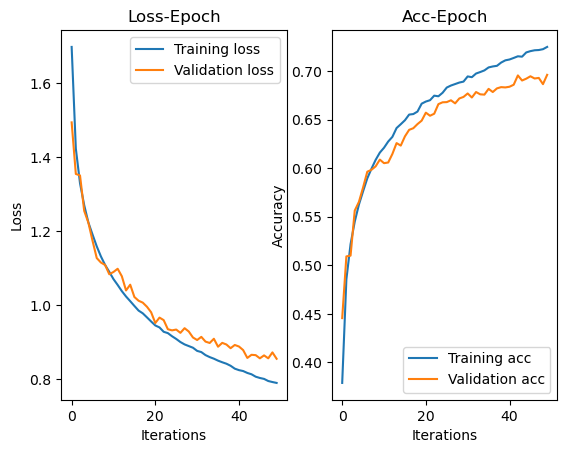

In [5]:
# Save dictionary as Pickle
with open("./result/adagrad-dropout-loss-50.pkl", "wb") as loss_file:
    pickle.dump(loss_hists, loss_file)
with open("./result/adagrad-dropout-acc-50.pkl", "wb") as acc_file:
    pickle.dump(acc_hists, acc_file)

# draw the loss figures
fig, ax = plt.subplots(1,2)
ax[0].plot(torch.tensor(loss_hists['train']).cpu().detach().numpy()) # can only matplotlib to plot numpy on CPU
ax[0].plot(torch.tensor(loss_hists['test']).cpu().detach().numpy())
ax[0].set_title('Loss-Epoch')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Loss')
ax[0].legend(['Training loss', 'Validation loss'])

ax[1].plot(torch.tensor(acc_hists['train']).cpu().detach().numpy())
ax[1].plot(torch.tensor(acc_hists['test']).cpu().detach().numpy())
ax[1].set_title('Acc-Epoch')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Accuracy')
ax[1].legend(['Training acc', 'Validation acc'])
plt.show()

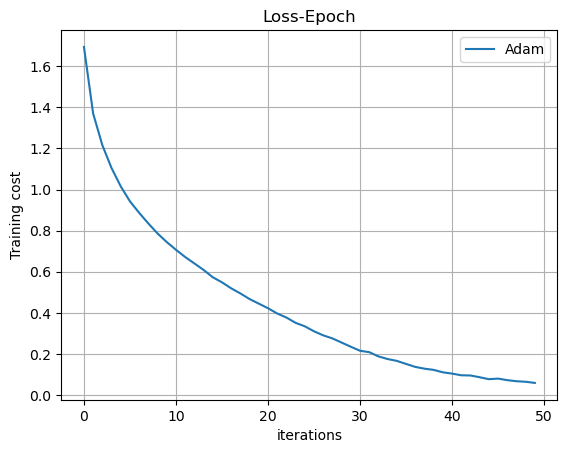

In [50]:
# draw the loss figures
with open('./result/adam-loss-50.pkl','rb') as f:
    loss_hists = pickle.load(f)
 

plt.plot(torch.tensor(loss_hists['train']).cpu().detach().numpy())
# Customize the plot
plt.xlabel('iterations')  # X-axis label
plt.ylabel('Training cost')  # Y-axis label
plt.title('Loss-Epoch')  # Title
plt.grid(True)  # Add grid lines
plt.legend(['Adam'])  # Add legend

# Show the plot
plt.show()

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=50):
        super(VAE, self).__init__()
        # Define the encoder layers
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 500),
            nn.Softplus(),
            nn.Linear(500, latent_dim * 2)  # Two sets of outputs: mean and log(variance)
        )
        
        # Define the decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 500),
            nn.Softplus(),
            nn.Linear(500, input_dim),
            nn.Sigmoid()  # Output values in the range [0, 1]
        )

    def encode(self, x):
        # Encode the input to get the mean and log(variance) of the latent space
        h = self.encoder(x)
        mean, log_var = h[:, :self.latent_dim], h[:, self.latent_dim:]
        return mean, log_var

    def reparameterize(self, mean, log_var):
        # Reparameterization trick: sample from the Gaussian with mean and variance
        epsilon = torch.randn_like(log_var)
        z = mean + torch.exp(0.5 * log_var) * epsilon
        return z

    def decode(self, z):
        # Decode the latent space representation
        return self.decoder(z)

    def forward(self, x):
        # Forward pass through the VAE
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        x_recon = self.decode(z)
        return x_recon, mean, log_var

# Define the loss function
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

class AdamOptimizer:
    def __init__(self, params, bias_cor, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.params = list(params)
        self.lr = torch.tensor(lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = torch.tensor(0)
        self.m = [torch.zeros_like(p) for p in self.params]  # 初始化self.m列表
        self.v = [torch.zeros_like(p) for p in self.params]  # 初始化self.v列表
        self.bias_cor = bias_cor

    def step(self):
        if self.bias_cor == True:
            self.t += 1
        lr_t = self.lr * (torch.sqrt(1 - self.beta2 ** self.t) / (1 - self.beta1 ** self.t))
        for i, p in enumerate(self.params):
            if p.grad is not None:
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * p.grad
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * p.grad ** 2
                m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                p.data -= lr_t * m_hat / (torch.sqrt(v_hat) + self.eps)

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.data.zero_()

            

In [30]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define hyperparameters
input_size = 784
hidden_size = 500
latent_size = 50
batch_size = 128
lr = 1e-3
beta1 = 0.9
beta2 = 0.999
num_epochs = 10
bias_correction = True

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
# Initialize VAE model and optimizer
model = VAE(input_size, latent_size)
# Create an instance of the Adam optimizer
adam_optimizer = AdamOptimizer(model.parameters(), bias_correction, lr, beta1, beta2)

# Training loop
for epoch in range(num_epochs):
    train_loss = 0
    for (data, _) in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        data = data.view(batch_size, -1)
        adam_optimizer.zero_grad()
        data_hat, mu, log_var = model(data)
        loss = loss_function(data, data_hat, mu, log_var)
        loss.backward()
        # Get gradients
        train_loss+=loss
        # Perform optimization step
        adam_optimizer.step()
        
    average_loss = train_loss/(len(train_loader)*batch_size)
        
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_loss:.4f}")

Epoch 1/10: 100%|██████████| 468/468 [00:14<00:00, 32.48it/s]


Epoch 1/10, Training Loss: 193.9590


Epoch 2/10: 100%|██████████| 468/468 [00:14<00:00, 32.98it/s]


Epoch 2/10, Training Loss: 138.8825


Epoch 3/10: 100%|██████████| 468/468 [00:14<00:00, 32.11it/s]


Epoch 3/10, Training Loss: 124.6981


Epoch 4/10: 100%|██████████| 468/468 [00:14<00:00, 32.31it/s]


Epoch 4/10, Training Loss: 117.6992


Epoch 5/10: 100%|██████████| 468/468 [00:15<00:00, 29.32it/s]


Epoch 5/10, Training Loss: 114.0754


Epoch 6/10: 100%|██████████| 468/468 [00:16<00:00, 27.72it/s]


Epoch 6/10, Training Loss: 111.8835


Epoch 7/10: 100%|██████████| 468/468 [00:14<00:00, 33.03it/s]


Epoch 7/10, Training Loss: 110.2804


Epoch 8/10: 100%|██████████| 468/468 [00:17<00:00, 27.30it/s]


Epoch 8/10, Training Loss: 109.0882


Epoch 9/10: 100%|██████████| 468/468 [00:18<00:00, 24.79it/s]


Epoch 9/10, Training Loss: 108.1784


Epoch 10/10: 100%|██████████| 468/468 [00:14<00:00, 33.04it/s]

Epoch 10/10, Training Loss: 107.5031
